In [1]:
# import everything you need
from nipype import Node, Workflow
import nipype.interfaces.spm as spm
from nipype.interfaces.base import CommandLine
from nilearn import image as nlimg
from nilearn import masking as nlmask
from nilearn.plotting import plot_anat, plot_epi, plot_roi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nb
import os, re

200217-17:13:02,410 nipype.utils INFO:
	 Running nipype version 1.5.0-dev (latest: 1.4.2)


Gather necessary pre-requisites:

In [2]:
# define useful functions
# define show-slices function
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")


In [3]:
# get normalised GM/WM images to analyse in MultipleRegression model
# change norm_dir to vary between GM and WM analysis
norm_dir="/VBM/DARTEL_norm2mni_c1/"
images_mreg=[]

for i in os.listdir(norm_dir):
    match=re.match(r'(smwc.*\d{14,}.*.nii)', i)
    if match:
        images_mreg.append(os.path.join(norm_dir, match.group(0)))

print("Images where normalised only if included in study specific template!")
print(images_mreg, len(images_mreg))

# group them correctly
dep_norm=[]
con_norm=[]

for i in images_mreg:
    match_dep=re.match(r'.*DEP_.*.nii', i)
    match_con=re.match(r'.*CON_.*.nii', i)
    if match_dep:
        dep_norm.append(match_dep.group(0))
    elif match_con:
        con_norm.append(match_con.group(0))
    else:
        print("item in images_mreg does not match regex pattern! Investigate ... ")
    
print(dep_norm, len(dep_norm))
print(con_norm, len(con_norm))

Images where normalised only if included in study specific template!
['/VBM/DARTEL_norm2mni_c1/smwc1CON_T1_MPRAGE_SAG_ISO_0_9_0005_20160308162043.nii', '/VBM/DARTEL_norm2mni_c1/smwc1CON_T1_MPRAGE_SAG_ISO_0_9_0005_20160310090712.nii', '/VBM/DARTEL_norm2mni_c1/smwc1DEP_T1_MPRAGE_SAG_ISO_0_9_0005_20151216154455.nii', '/VBM/DARTEL_norm2mni_c1/smwc1CON_T1_MPRAGE_SAG_ISO_0_9_0005_20141210170232.nii', '/VBM/DARTEL_norm2mni_c1/smwc1DEP_T1_MPRAGE_SAG_ISO_0_9_0005_20151001173950.nii', '/VBM/DARTEL_norm2mni_c1/smwc1DEP_T1_MPRAGE_SAG_ISO_0_9_0005_20150929162030.nii', '/VBM/DARTEL_norm2mni_c1/smwc1DEP_T1_MPRAGE_SAG_ISO_0_9_0005_20151009111760.nii', '/VBM/DARTEL_norm2mni_c1/smwc1DEP_T1_MPRAGE_SAG_ISO_0_9_0005_20150219142148.nii', '/VBM/DARTEL_norm2mni_c1/smwc1CON_T1_MPRAGE_SAG_ISO_0_9_0005_20150211171144.nii', '/VBM/DARTEL_norm2mni_c1/smwc1DEP_T1_MPRAGE_SAG_ISO_0_9_0005_20141208163153.nii', '/VBM/DARTEL_norm2mni_c1/smwc1CON_T1_MPRAGE_SAG_ISO_0_9_0005_20160331140317.nii', '/VBM/DARTEL_norm2mni_c1/smw

In [44]:
# calculate "global values" via nibabel objects: sum up the values and multiply by volume of each voxel
# from: total volume GM, WM and CSF

# find all the files starting with "c1,c2,c3" in all subdirs of the VBM directory via CommandLine interface from nipype
c1_files=CommandLine('find', args='/VBM/FED* -maxdepth 2 -type f -name c1*.nii', terminal_output='allatonce')
c1=c1_files.run()
c2_files=CommandLine('find', args='/VBM/FED* -maxdepth 2 -type f -name c2*.nii', terminal_output='allatonce')
c2=c2_files.run()
c3_files=CommandLine('find', args='/VBM/FED* -maxdepth 2 -type f -name c3*.nii', terminal_output='allatonce')
c3=c3_files.run()
# read the output (find stdout) line by line to list object
globals_GM=c1.runtime.stdout.splitlines()
globals_WM=c2.runtime.stdout.splitlines()
globals_CSF=c3.runtime.stdout.splitlines()
# create nibabel objects from all files
globals_GM_nb=[nb.load(i) for i in globals_GM]
globals_WM_nb=[nb.load(i) for i in globals_WM]
globals_CSF_nb=[nb.load(i) for i in globals_CSF]
# create list with the func data via dataobj property (avoids caching entire object (.fdata()) but gets func data as well)
globals_GM_fvals=[i.dataobj for i in globals_GM_nb]
globals_WM_fvals=[i.dataobj for i in globals_WM_nb]
globals_CSF_fvals=[i.dataobj for i in globals_CSF_nb]

Testing Zone:

In [197]:
# test multiplication scheme
#a=np.full((5,5,5,), 2.4567)
#a[:, 0] = 0
#b=np.full((5,5,5,), 2.4567)
#b[:, :,0] = 0
#c=np.full((5,5,5,), 2.4567)
#c[:, :,-1] = 0
#d=np.full((5,5,5,), 2.4567)
#d[:, -1,:] = 0
#e=a*b*c*d
#print(e) # -> seems to work ok, also with float data

0.79101133


In [202]:
# 0 values outside the brain in each volume -> 0 vals overbias and make globals smaller
# c1,2,3 also are not normalised -> different positions for different subjects
# -> take all c images and calculate below values for all substances ;)


print(np.sum(globals_CSF_fvals[0][:,:,:][globals_CSF_fvals[0][:,:,:] != 0])
      / np.size(globals_CSF_fvals[0][:,:,:][globals_CSF_fvals[0][:,:,:] != 0]))

print((np.sum(globals_CSF_fvals[0][:,:,:][globals_CSF_fvals[0][:,:,:] != 0])
      * np.product(globals_CSF_nb[0].header['pixdim'][1:4]))
      / np.size(globals_CSF_fvals[0][:,:,:][globals_CSF_fvals[0][:,:,:] != 0]))

print((np.sum(globals_CSF_fvals[0][:,:,:][globals_CSF_fvals[0][:,:,:] != 0])
      * np.product(globals_CSF_nb[0].header['pixdim'][1:4])))

# for good overview
print(np.size(globals_CSF_fvals[0][96,128,:][globals_CSF_fvals[0][96,128,:] != 0]),
      np.sum(globals_CSF_fvals[0][96,128,:][globals_CSF_fvals[0][96,128,:] != 0]),
      globals_CSF_fvals[0][96,128,:][globals_CSF_fvals[0][96,128,:] != 0])

0.3378729847597221
0.2672613602167821
215391.54268726925
93 72.93333764653653 [0.0509804  0.18039217 0.27058825 0.16078432 0.5921569  0.85882358
 0.90980398 0.96078437 0.96862751 0.97254908 0.97254908 0.97254908
 0.95294123 0.92941182 0.98823535 0.99607849 1.00000006 1.00000006
 1.00000006 1.00000006 1.00000006 1.00000006 1.00000006 1.00000006
 0.92941182 0.02745098 0.0509804  0.54901964 1.00000006 1.00000006
 1.00000006 1.00000006 1.00000006 1.00000006 1.00000006 1.00000006
 1.00000006 1.00000006 1.00000006 1.00000006 1.00000006 1.00000006
 1.00000006 1.00000006 0.86666672 0.37254904 0.02352941 0.24313727
 0.80392162 0.83529417 0.00392157 0.00392157 0.8941177  1.00000006
 1.00000006 1.00000006 0.22352942 0.45882356 0.85882358 1.00000006
 1.00000006 1.00000006 0.94117653 0.52549023 0.14901962 0.10196079
 0.14117648 0.15686275 0.8941177  1.00000006 1.00000006 1.00000006
 1.00000006 0.92549025 1.00000006 1.00000006 1.00000006 1.00000006
 1.00000006 0.91372554 0.85098044 0.7803922  0.6901

In [46]:
# check size of items and delete them when above a certain threshold
from sys import getsizeof # function is not fully indicative -> look for better option
items=[globals_GM_nb,globals_WM_nb,globals_CSF_nb,c1,c2,c3]
for i in items:
    # return size of object in bytes
    print("size of item", i, "is:", getsizeof(i))
    if getsizeof(i) > 10000: # think about dynamic coding fro this
        del i
        print("deleted, object exceeded set threshold.")
    else:
        print("retained, object is sufficiently small.")

size of item [<nibabel.nifti1.Nifti1Image object at 0x7f6782eba910>, <nibabel.nifti1.Nifti1Image object at 0x7f6785c21810>, <nibabel.nifti1.Nifti1Image object at 0x7f6782c8d810>, <nibabel.nifti1.Nifti1Image object at 0x7f6782c8de90>, <nibabel.nifti1.Nifti1Image object at 0x7f6782c8d410>, <nibabel.nifti1.Nifti1Image object at 0x7f6782c8df90>, <nibabel.nifti1.Nifti1Image object at 0x7f6782c8d710>, <nibabel.nifti1.Nifti1Image object at 0x7f6782c8d850>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca3ed0>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca3550>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca3290>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca38d0>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca3a50>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca3c50>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca3790>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca30d0>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca7890>, <nibabel.nifti1.Nifti1Image object at 0x7f6782ca7bd

Text(0.5, 0.98, 'Centre slice for c1 struct image')

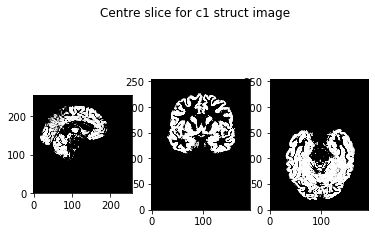

In [10]:
show_slices([globals_nbfvals[25][96,:,:],globals_nbfvals[25][:,128,:],globals_nbfvals[25][:,:,128]])
plt.suptitle("Centre slice for c1 struct image")

In [ ]:
# create multiple regression Node
mreg=Node(spm.MultipleRegressionDesign(), name="MultipleRegression")
mreg.inputs.in_files=
mreg.inputs.global_calc_values=
# use proportional global normalization
mreg.inputs.global_normalization=2
mreg.inputs.threshold_mask_absolute=
# think of mask image to threshold
#mreg.inputs.explicit_mask_file=
mreg.inputs.covariates=
results=mreg.run()
print(results.outputs)